In [1]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReWOO"
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")

In [2]:
from typing import List, TypedDict


class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

In [3]:
from langchain_openai import ChatOpenAI

import os

os.environ['DEEPSEEK_API_KEY'] = os.getenv("DEEPSEEK_API_KEY")
model = ChatOpenAI(
    model="deepseek-chat",  # DeepSeek的聊天模型
    temperature=0,
    openai_api_key=os.getenv("DEEPSEEK_API_KEY"),  # 从DeepSeek获取的API key
    openai_api_base="https://api.deepseek.com/v1"  # DeepSeek的Base URL
)

In [4]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [5]:
task = "2024年澳大利亚网球公开赛冠军的家乡是哪里?"

# In[7]:


result = model.invoke(prompt.format(task=task))

In [6]:
print(result.content)

Plan: 首先，我需要查找2024年澳大利亚网球公开赛的冠军是谁。由于这是一个具体的体育赛事结果，我将使用Google搜索来获取准确信息。 #E1 = Google[2024年澳大利亚网球公开赛冠军]

Plan: 根据#E1的结果，我将确认冠军的姓名。然后，我需要查找这位冠军的家乡信息。由于家乡可能涉及个人背景，我将再次使用Google搜索来获取详细信息。 #E2 = Google[2024年澳网冠军 家乡]

Plan: 如果#E2提供了明确的家乡信息，我将直接输出答案。如果信息不完整或需要进一步验证，我将使用LLM来辅助整合和确认信息，确保准确性。 #E3 = LLM[根据#E1和#E2，确认2024年澳网冠军的家乡是哪里？]


In [7]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

C:\Users\sheng\AppData\Local\Temp\ipykernel_17492\910133487.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults()


In [9]:
def _get_current_task(state: ReWOO):
    if state.get("results") is None:  # 不存在时返回 None
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = state["results"] or {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

In [10]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""

In [11]:
def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = state["results"] or {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

In [12]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"


In [13]:

from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

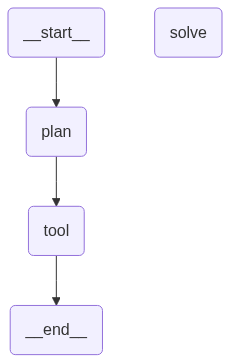

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [('首先，我需要找到2024年澳大利亚网球公开赛的冠军是谁。由于这是一个具体的体育赛事结果，我可以使用Google搜索来获取准确的信息。 ', '#E1', 'Google', '2024年澳大利亚网球公开赛冠军'), ('根据#E1的结果，我将得知冠军的姓名。然后，我需要查找这位冠军的家乡信息。这可能需要进一步的搜索，因为家乡信息可能不是直接包含在初始搜索结果中。 ', '#E2', 'Google', '#E1冠军的家乡'), ('如果#E2的搜索结果不够明确或详细，我可能需要使用LLM来基于已知的冠军信息推断或回忆其家乡。LLM可以提供一般性知识或上下文信息。 ', '#E3', 'LLM', '#E1冠军的出生地或家乡是哪里？'), ('最后，我将整合所有收集到的证据，确认冠军的家乡，并确保信息的准确性。如果需要，可以交叉验证不同来源的信息。 ', '#E4', 'LLM', '验证#E1冠军的家乡是#E2或#E3，并确认一致性')], 'plan_string': 'Plan: 首先，我需要找到2024年澳大利亚网球公开赛的冠军是谁。由于这是一个具体的体育赛事结果，我可以使用Google搜索来获取准确的信息。 #E1 = Google[2024年澳大利亚网球公开赛冠军]\n\nPlan: 根据#E1的结果，我将得知冠军的姓名。然后，我需要查找这位冠军的家乡信息。这可能需要进一步的搜索，因为家乡信息可能不是直接包含在初始搜索结果中。 #E2 = Google[#E1冠军的家乡]\n\nPlan: 如果#E2的搜索结果不够明确或详细，我可能需要使用LLM来基于已知的冠军信息推断或回忆其家乡。LLM可以提供一般性知识或上下文信息。 #E3 = LLM[#E1冠军的出生地或家乡是哪里？]\n\nPlan: 最后，我将整合所有收集到的证据，确认冠军的家乡，并确保信息的准确性。如果需要，可以交叉验证不同来源的信息。 #E4 = LLM[验证#E1冠军的家乡是#E2或#E3，并确认一致性]'}}
---


KeyError: 'results'